# Create a topological network from spatial data

`snkit` helps with spatial networks problems, mainly the kind of thing that comes up in data cleaning, tidying and pre-processing.

This notebook goes through a cleaning process:
- read in a set of nearly-connected points and lines
- add nodes at the line endpoints
- links the remaining points to the existing lines (if they're within a specified distance)
- give everything a unique ID
- add from/to ids to the edges

The data is output in a state ready to be used as a network graph for further analysis.

In [1]:
import snkit
import snkit.network
import networkx
import pandas
import geopandas
import matplotlib.pyplot as plt

In [2]:
data = geopandas.read_file('small-demo.geojson')
data

,geometry
0,"LINESTRING (0.00412 -0.04086, 0.00034 -0.03347..."
1,"LINESTRING (0.01768 -0.01236, 0.01768 -0.02369..."
2,"LINESTRING (0.02970 0.01888, 0.01888 0.01820, ..."
3,POINT (0.03090 0.04429)
4,POINT (0.03090 0.03759)
5,POINT (0.02129 0.03948)
6,POINT (0.02987 -0.02180)
7,POINT (0.03759 -0.02798)
8,POINT (-0.00275 -0.02867)
9,POINT (-0.00120 -0.03811)


In [3]:
edges = data[:3]
nodes = data[3:]

In [4]:
def plot_network(n):
    df = pandas.concat([n.nodes, n.edges], axis=0, sort=False)
    df.plot()

A network consists of nodes and edges - `snkit` stores these as two separate `GeoDataFrame`s.

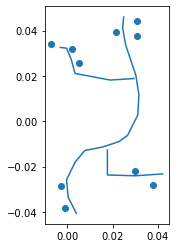

In [5]:
base_network = snkit.Network(nodes, edges)
plot_network(base_network)

Add points at the end of each line. This uses the first and last coordinate pair from each `LineString` geometry and creates a node at each point.

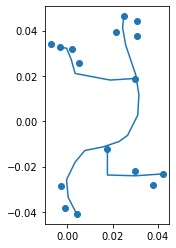

In [6]:
with_endpoints = snkit.network.add_endpoints(base_network)
plot_network(with_endpoints)

Links each point to any (all) edges within a distance threshold.

For a typical edge, this:
- finds any nodes within the given distance
- creates new straight-line edges from the edge directly to each node
- splits the original edge at each point where the new edges intersect

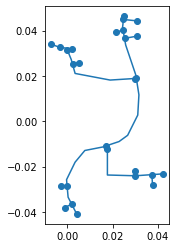

In [7]:
linked = snkit.network.link_nodes_to_edges_within(with_endpoints, 0.01)
plot_network(linked)

Linking nodes is sensitive to the distance parameter - depending on the dataset or problem, some nodes will not be connected if they are too far from the nearest line (see top right in the figure below).

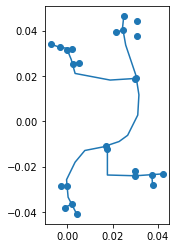

In [8]:
linked_n = snkit.network.link_nodes_to_edges_within(with_endpoints, 0.005)
plot_network(linked_n)

Add IDs to each node and edge, then add topology, recording the ids of nodes at each end of each edge. 

This is saved as `from_id` and `to_id` but `snkit` currently has no opinion about direction or ordering - from/to could easily be reversed.

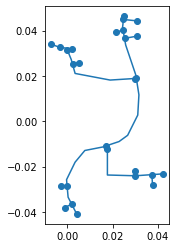

In [9]:
with_topology = snkit.network.add_topology(snkit.network.add_ids(linked))
plot_network(with_topology)

Preview data.

In [10]:
with_topology.nodes.head()

,geometry,id
0,POINT (0.03090 0.04429),node_0
1,POINT (0.03090 0.03759),node_1
2,POINT (0.02129 0.03948),node_2
3,POINT (0.02987 -0.02180),node_3
4,POINT (0.03759 -0.02798),node_4


In [11]:
with_topology.edges.head()

,geometry,id,from_id,to_id
0,"LINESTRING (0.00412 -0.04086, 0.00190 -0.03652)",edge_0,node_10,node_22
1,"LINESTRING (0.00190 -0.03652, 0.00034 -0.03347...",edge_1,node_22,node_21
2,"LINESTRING (-0.00010 -0.02843, -0.00034 -0.025...",edge_2,node_21,node_25
3,"LINESTRING (0.01717 -0.01081, 0.02283 -0.00893...",edge_3,node_25,node_26
4,"LINESTRING (0.03044 0.01900, 0.03021 0.02043, ...",edge_4,node_26,node_17


Save the data to a [geopackage](https://www.geopackage.org/) for later visualisation or analysis:

In [12]:
with_topology.nodes.to_file('network.gpkg', layer='nodes', driver='GPKG', index=False)
with_topology.edges.to_file('network.gpkg', layer='edges', driver='GPKG', index=False)

Convert to [`networkx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html)

In [13]:
G = snkit.network.to_networkx(with_topology)

..which gives us access to a whole host of algorithms in the `networkx` library.

For example, we can find the shortest path between two nodes:

In [14]:
networkx.shortest_path(G, 'node_0', 'node_10')

['node_0',
 'node_16',
 'node_18',
 'node_17',
 'node_26',
 'node_25',
 'node_21',
 'node_22',
 'node_10']